<a href="https://colab.research.google.com/github/amarathe/RetinalRecognition/blob/master/project_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Retinal OCT Images recognition
# Sharanjeet Singh, Ashwin Marathe
Classify images of retina
4 categories: 
    CNV - Choroidal neovascularization
    DME -  Diabetic macular edema 
    DRUSEN - Multiple drusen
    NORMAL - Normal retina

84,000 images in dataset
    
https://www.kaggle.com/paultimothymooney/kermany2018/data#CNV-1016042-2.jpeg

In [4]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image
import pandas as pd
import os.path
from os import path

BATCHSIZE = 64
NSAMPLES = 10000

#Instructions for getting dataset from kaggle:
# https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8
from google.colab import files
!pip install -q kaggle
#Upload your kaggle.json API file

if not path.exists("/root/.kaggle/kaggle.json"): 
  uploaded = files.upload()
  os.system("mv kaggle.json ~/.kaggle/kaggle.json")
#!ls -halt ~/.kaggle
  os.system("chmod 600 ~/.kaggle/kaggle.json")
!kaggle datasets download -d paultimothymooney/kermany2018

Saving kaggle.json to kaggle.json
100% 10.8G/10.8G [04:20<00:00, 41.3MB/s]
100% 10.8G/10.8G [04:20<00:00, 44.7MB/s]


In [5]:
%matplotlib inline


import zipfile
if not path.exists("kermany2018"):
  with zipfile.ZipFile("kermany2018.zip","r") as zip_ref:
    zip_ref.extractall("kermany2018")

#!ls "kermany2018/OCT2017 "
train_datagen = ImageDataGenerator(rescale=1./256, validation_split=0.2)
#valid_datagen = ImageDataGenerator(rescale=1./256)
test_datagen = ImageDataGenerator(rescale=1./256)

# load and iterate training dataset
train_generator = train_datagen.flow_from_directory('kermany2018/OCT2017 /train/', class_mode='categorical', 
                                             target_size=(512,512), batch_size=BATCHSIZE, subset="training")

#Only 32 images in validation dataset - too small. Use test train split from train dataset
# load and iterate validation dataset
#valid_generator = valid_datagen.flow_from_directory('kermany2018/OCT2017 /val/', class_mode='categorical', 
#                                           target_size=(512,512), batch_size=BATCHSIZE)
valid_generator = train_datagen.flow_from_directory('kermany2018/OCT2017 /train/', class_mode='categorical', 
                                             target_size=(512,512), batch_size=BATCHSIZE, subset="validation")
# load and iterate test dataset
test_generator = test_datagen.flow_from_directory('kermany2018/OCT2017 /test/', class_mode='categorical', 
                                           target_size=(512,512), batch_size=BATCHSIZE)

#traindf = pd.read_csv('kermany2018.zip')

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [0]:
#Returns model and model before last activation (for debug)
def get_model():
    x = x_in = Input((512,512,3), name="input")
    x = Conv2D(8, (3,3), padding="same",  name="fe0")(x)
    x = Activation("relu", name="r0")(x)
    x = MaxPooling2D(2,2,name="mp0")(x)
    x = BatchNormalization(name="bn1")(x)
    x = Conv2D(16, (3,3), padding="same", name="fe1")(x)
    x = Activation("relu", name="r1")(x)
 #   x = MaxPooling2D(2,2,name="mp1")(x)
    x = BatchNormalization(name="bn2")(x)
    x = Conv2D(16, (3,3), padding="same", name="fe2")(x)
    x = Activation("relu", name="r2")(x)
    x = MaxPooling2D(2,2,name="mp2")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Conv2D(32, (3,3), padding="same", name="fe3")(x)
    x = Activation("relu", name="r3")(x)
    x = BatchNormalization(name="bn4")(x)
    x = Conv2D(32, (3,3), padding="same", name="fe4")(x)
    x = Activation("relu", name="r4")(x)
    x = MaxPooling2D(2,2,name="mp3")(x)   
    x = Dropout(0.5, name="d0")(x)
    x = Flatten(name="fl")(x)
    #x = Dense(64, name="d0", activation="relu")(x)
    x = Dense(4, name="d1")(x)
    x = x_int = Activation("softmax", name="s1")(x)
    m = Model(inputs=x_in, outputs=x)
    m_int = Model(inputs=x_in, outputs=x_int)
    m.summary()
    return m, m_int


In [11]:
model, model_int = get_model()
adam = Adam(lr=0.001)
adam = Adam(lr=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["acc"])

result = model.evaluate_generator(test_generator)
print ("Test results: Accuracy", result[1])
print ("\t Loss:", result[0])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=NSAMPLES//BATCHSIZE, # number of times it executes until it declares epoch is over.
    epochs=20,
    validation_data=valid_generator,
    validation_steps=NSAMPLES//(4*BATCHSIZE))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 3)       0         
_________________________________________________________________
fe0 (Conv2D)                 (None, 512, 512, 8)       224       
_________________________________________________________________
r0 (Activation)              (None, 512, 512, 8)       0         
_________________________________________________________________
mp0 (MaxPooling2D)           (None, 256, 256, 8)       0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 256, 256, 8)       32        
_________________________________________________________________
fe1 (Conv2D)                 (None, 256, 256, 16)      1168      
_________________________________________________________________
r1 (Activation)              (None, 256, 256, 16)      0   

In [17]:
#for data_batch, labels_batch in train_generator:
#  prediction = model.predict(data_batch)
#  print ("Prediction:", prediction)
#  print ("labels:", labels_batch)
#  break

result = model.evaluate_generator(test_generator)
print ("Test results: Accuracy", result[1])
print ("\t Loss:", result[0])


Test results: Accuracy 0.5816115702479339
	 Loss: 4.5099803751165215


In [0]:
import matplotlib.pyplot as plt
def plothistory(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

# Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

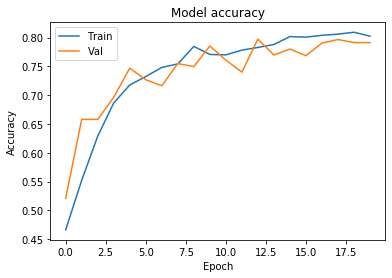

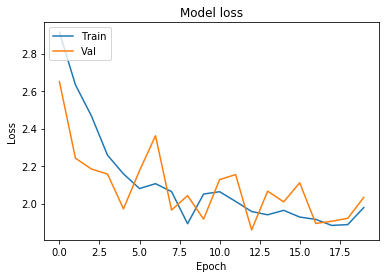

In [23]:
plothistory(history)

# Image characteristics

In [0]:

from PIL import Image as IMG
image = IMG.open("/Users/ashwinmarathe/Documents/ELEN521/project/OCT2017/OCT2017 /train/CNV/CNV-1016042-1.jpeg")
#Image details
print("format:", image.format)
print("mode:", image.mode)
print("size:", image.size)

In [0]:
Image(filename="/Users/ashwinmarathe/Documents/ELEN521/project/OCT2017/OCT2017 /train/CNV/CNV-1016042-1.jpeg")


In [0]:
from os import listdir
from matplotlib import image
from scipy.special import comb
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time
import pandas as pd

#Load 100 images
def loadFromDir(location, x, y, yval, n=100):
    for filename in listdir(location)[:100]:
        img_data = image.imread(location + filename)
        #Make this uniform size
        img_data = cv2.resize(img_data, dsize=(496, 512), interpolation=cv2.INTER_CUBIC)
        x.append(img_data)
        y.append(yval)
        
    
x_train = []
y_train = []
location = "/Users/ashwinmarathe/Documents/ELEN521/project/OCT2017/OCT2017 /train/CNV/"
loadFromDir(location, x_train, y_train, 1)
location = "/Users/ashwinmarathe/Documents/ELEN521/project/OCT2017/OCT2017 /train/DME/"
loadFromDir(location, x_train, y_train, 2)
location = "/Users/ashwinmarathe/Documents/ELEN521/project/OCT2017/OCT2017 /train/DRUSEN/"
loadFromDir(location, x_train, y_train, 3)
location = "/Users/ashwinmarathe/Documents/ELEN521/project/OCT2017/OCT2017 /train/NORMAL/"
loadFromDir(location, x_train, y_train, 4)

print ("x_train[0] dim:", x_train[0].shape)
print ("x_train[1] dim:", x_train[1].shape)
print ("x_train[2] dim:", x_train[2].shape)
print ("x_train[3] dim:", x_train[3].shape)

x_train = np.vstack(np.expand_dims(x_train, axis=0))
y_train = np.vstack(np.array(y_train))
print ("x_train shape:", x_train.shape)
print ("y_train shape:", y_train.shape)

    

In [0]:
indexes = x_train.shape[0]
print ("x_train shape", x_train.shape)
indexes = np.random.permutation(indexes)
indexes

x_train = x_train[indexes]
y_train = y_train[indexes]

plt.gray()
fig = plt.figure( figsize=(16,14) )
for i in range(0,9):
    x = x_train[i]
    y = y_train[i]
    ax = fig.add_subplot(3,3,i+1, title="Disease: {}".format(str(y)))
    ax.matshow(x)
plt.show()

In [0]:
print ("x_train.shape", x_train[0].shape)
print ("x_train:", x_train)
x_train_flatten = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
y_train_flatten = y_train.reshape(y_train.shape[0])
#x_train_flatten = x_train_flatten[0:1000]
#y_train_flatten = y_train_flatten[0:1000]
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x_train_flatten)

In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y_train_flatten, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()


In [0]:
# tSNE is very expensive to compute. Let's use only 400 samples
x_train_flatten = x_train_flatten[0:400]
y_train_flatten = y_train_flatten[0:400]
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_train_flatten)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [0]:
data = {"x{}".format(i): x_train_flatten[:, i] for i in range(x_train_flatten.shape[1])}
data["y"] = y_train_flatten
df = pd.DataFrame(data)
df

In [0]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.3
)

In [0]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(x_train_flatten)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

In [0]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result_50)

In [0]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.3
)